In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklego.linear_model import LowessRegression
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [2]:
metadata = pd.read_csv("../Dataset/Zaporozhchenko2018/E-MTAB-6304.sdrf.txt", sep="\t", index_col=0)

In [3]:
set(metadata["Characteristics[tumor grading]"])

{'  ', '1a/1b', '2a/2b', '2b', '3a'}

In [4]:
data = pd.read_csv("../Dataset/Zaporozhchenko2018/NSCLC_miRNA_dis_set.txt", sep="\t", na_values=["ND"])
data.head()

,Unnamed: 0,cel-miR-39-3p CP,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-5p,hsa-let-7f-5p,...,hsa-miR-885-5p,hsa-miR-92a-3p,hsa-miR-92b-3p,hsa-miR-93-3p,hsa-miR-93-5p,hsa-miR-95,hsa-miR-99a-5p,hsa-miR-99b-5p,UniSp3 IPC,UniSp6 CP
0,NaN,107.0,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.0,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
1,H01,NaN,28.758668,34.982437,28.984358,33.021168,33.031645,32.134888,33.872718,31.636085,...,NaN,28.593853,NaN,37.119241,30.343426,NaN,32.538680,34.652577,21.179529,20.609685
2,S03,NaN,29.712003,36.534820,30.825836,33.290056,32.817465,32.539219,34.332494,32.621527,...,NaN,28.461714,NaN,NaN,30.262072,35.938857,31.901907,33.866242,21.093227,20.317635
3,S12,NaN,29.991424,32.970275,31.918557,33.476899,31.122068,32.842620,35.439817,32.170137,...,34.214609,26.554790,NaN,33.643150,27.108517,34.208271,31.094495,33.481884,21.196356,20.282360
4,A05,NaN,28.978809,36.295561,30.336321,32.794001,32.324980,32.813790,33.523878,30.966500,...,35.877971,28.043598,NaN,35.501765,28.781016,34.825218,32.034844,33.841013,20.977626,20.315291


In [5]:
data = data[1:-1]

### Remove outlier

In [6]:
data = data.drop([5, 15, 21]) #, 14, 19, 21])

In [7]:
mirnas = data.columns[1:]
table = data.set_index("Unnamed: 0")
table.head()

,cel-miR-39-3p CP,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-5p,hsa-let-7f-5p,hsa-let-7g-5p,...,hsa-miR-885-5p,hsa-miR-92a-3p,hsa-miR-92b-3p,hsa-miR-93-3p,hsa-miR-93-5p,hsa-miR-95,hsa-miR-99a-5p,hsa-miR-99b-5p,UniSp3 IPC,UniSp6 CP
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
H01,NaN,28.758668,34.982437,28.984358,33.021168,33.031645,32.134888,33.872718,31.636085,29.808525,...,NaN,28.593853,NaN,37.119241,30.343426,NaN,32.538680,34.652577,21.179529,20.609685
S03,NaN,29.712003,36.534820,30.825836,33.290056,32.817465,32.539219,34.332494,32.621527,30.447355,...,NaN,28.461714,NaN,NaN,30.262072,35.938857,31.901907,33.866242,21.093227,20.317635
S12,NaN,29.991424,32.970275,31.918557,33.476899,31.122068,32.842620,35.439817,32.170137,28.607708,...,34.214609,26.554790,NaN,33.643150,27.108517,34.208271,31.094495,33.481884,21.196356,20.282360
A05,NaN,28.978809,36.295561,30.336321,32.794001,32.324980,32.813790,33.523878,30.966500,29.184318,...,35.877971,28.043598,NaN,35.501765,28.781016,34.825218,32.034844,33.841013,20.977626,20.315291
S11,NaN,28.234000,32.777309,28.548604,32.047543,30.254140,31.525169,32.761623,31.622205,28.077539,...,35.857980,26.668311,NaN,33.467991,25.861484,35.559428,30.991698,32.896229,21.140280,20.891393


In [8]:
controls = np.array(["H" in r for r in data.iloc[:, 0]])
sum(controls)

10

### Mean-variance-plot

In [9]:
mask = table.isna().sum() <= 20
table = table.loc[:, mask]
mirnas = mirnas[mask]

In [10]:
table = table.fillna(table.min().min())

In [11]:
len(table)

27

In [12]:
np.mean(table)

hsa-let-7a-5p     29.236889
hsa-let-7b-3p     32.473054
hsa-let-7b-5p     29.706266
hsa-let-7c        33.032204
hsa-let-7d-3p     30.932542
                    ...    
hsa-miR-95        31.349485
hsa-miR-99a-5p    30.907213
hsa-miR-99b-5p    32.562831
UniSp3 IPC        21.257422
UniSp6 CP         20.737558
Length: 177, dtype: float64

In [13]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [14]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

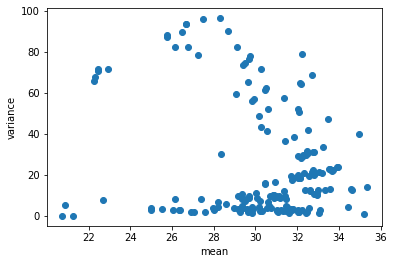

In [15]:
mean_variance_plot(table)

### Log transformation

In [16]:
log_table = table #np.log2(table)

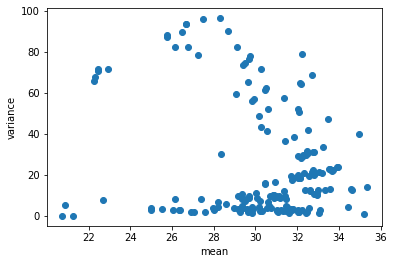

In [17]:
mean_variance_plot(log_table)

### Loess regression

In [18]:
lowess = LowessRegression(sigma=1, span=0.5)

In [19]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.5)

In [20]:
x_axis = np.linspace(30, 40, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

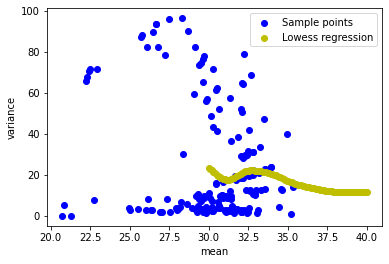

In [21]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

In [22]:
adj_var = lowess.predict(means.to_numpy().reshape(-1, 1))

In [23]:
log_table /= np.sqrt(adj_var)

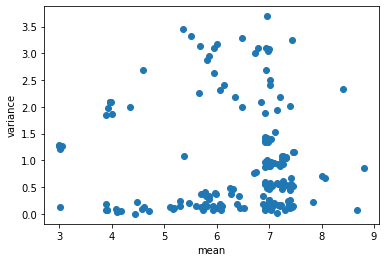

In [24]:
mean_variance_plot(log_table)

### Standardizing

In [25]:
norm_log_table = log_table #- np.mean(log_table)

In [26]:
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

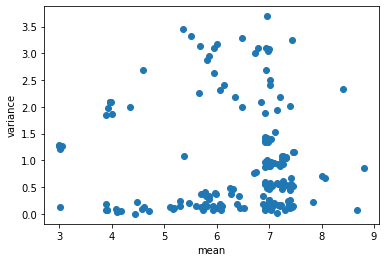

In [27]:
mean_variance_plot(norm_log_table)

### PCA

In [28]:
pca = decomposition.PCA(n_components=10)

In [29]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [30]:
pca.explained_variance_ratio_

array([0.31689202, 0.10680122, 0.07178314, 0.05852772, 0.05698059,
       0.04600932, 0.04147007, 0.03918732, 0.03355463, 0.02977775])

In [31]:
components = pca.transform(norm_log_table)

In [32]:
components

array([[ 1.77432442e+00, -6.51359256e+00, -1.91655945e+00,
         7.90698574e+00, -2.62719716e+00, -2.74882419e+00,
         2.02863262e+00,  5.57637776e+00, -9.51811332e-01,
        -2.53155185e-01],
       [-8.65010733e-01, -4.67149858e+00, -2.63553562e+00,
        -7.55352152e-01,  1.32674541e-01, -4.51832097e+00,
        -3.63787403e+00, -4.14663526e+00, -5.40361731e+00,
         2.37384296e+00],
       [-2.96919723e+00,  3.44677862e+00,  2.37227153e+00,
         2.82197664e-01,  4.42600136e-01, -3.77445547e-01,
         2.61700266e+00, -3.69189217e+00,  1.29568928e+00,
         2.87158609e+00],
       [-1.59615681e+00, -8.59541700e-01, -1.20124239e-01,
         1.10474916e+00,  1.85135606e+00,  8.73619149e-01,
         7.83328782e+00,  1.75790389e+00, -2.05564855e+00,
        -4.80338437e-02],
       [-2.98128796e+00,  2.93762957e+00,  8.23603611e-01,
         2.14212806e-01,  2.04831697e+00,  5.25328721e-01,
         7.05466511e-01,  6.08623344e-01, -7.23117969e-01,
        -2.

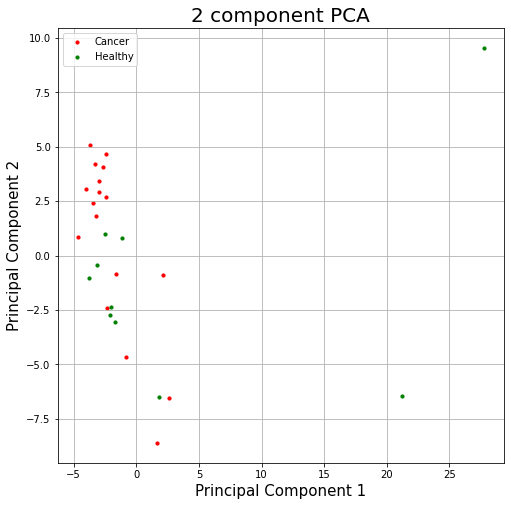

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [34]:
np.nonzero(components[:, 1] > 8)

(array([16], dtype=int64),)

In [35]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

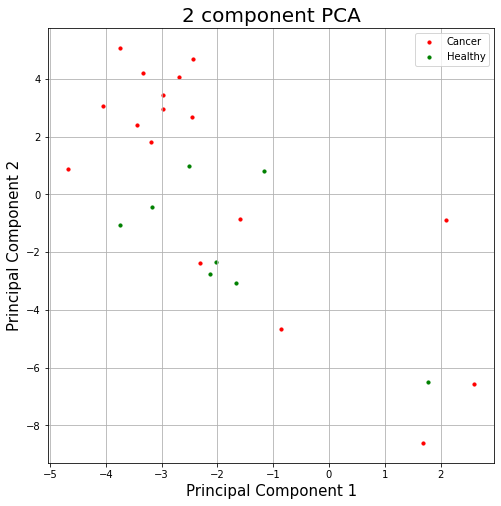

In [36]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [37]:
metadata.columns

Index(['Characteristics[organism]', 'Characteristics[disease]',
       'Characteristics[tumor grading]', 'Characteristics[age]',
       'Unit[time unit]', 'Characteristics[sex]',
       'Characteristics[organism part]', 'Material Type', 'Protocol REF',
       'Protocol REF.1', 'Extract Name', 'Protocol REF.2',
       'Labeled Extract Name', 'Label', 'Protocol REF.3', 'Assay Name',
       'Technology Type', 'Array Design REF', 'Term Source REF',
       'Protocol REF.4', 'Array Data Matrix File',
       'Comment [ArrayExpress Data Matrix FTP file]', 'Protocol REF.5',
       'Derived Array Data File', 'Comment [Derived ArrayExpress FTP file]',
       'Factor Value[disease]'],
      dtype='object')

In [38]:
covars = metadata.loc[table.index, ["Characteristics[age]", "Characteristics[sex]"]]

In [39]:
covars.columns = ["age", "sex"]

In [40]:
covars["sex"] = covars["sex"] == "female"

In [41]:
covars = covars.fillna(covars.mean())

In [42]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

LinearRegression()

In [43]:
adj_norm_log_table = norm_log_table #- linreg.predict(covars)

# PCA

In [44]:
pca = decomposition.PCA(n_components=2)

In [45]:
pca.fit(adj_norm_log_table)

PCA(n_components=2)

In [46]:
components = pca.transform(adj_norm_log_table)

In [47]:
components

array([[ 1.77432442, -6.51359256],
       [-0.86501073, -4.67149858],
       [-2.96919723,  3.44677862],
       [-1.59615681, -0.8595417 ],
       [-2.98128796,  2.93762957],
       [-3.3395322 ,  4.20010825],
       [-2.6812646 ,  4.07477572],
       [-3.16344673, -0.4298631 ],
       [-3.73591179,  5.0750672 ],
       [-1.15883381,  0.81383871],
       [-4.67170336,  0.86456014],
       [ 1.67642088, -8.61256536],
       [21.23775176, -6.45960234],
       [-4.04165238,  3.06721092],
       [ 2.60018659, -6.55962354],
       [-2.50829592,  0.98829292],
       [27.74148947,  9.55112318],
       [-3.43141272,  2.413244  ],
       [-2.02332516, -2.34241991],
       [-3.18522362,  1.79746971],
       [-2.31135489, -2.38971435],
       [-2.45821944,  2.68903882],
       [-1.66692886, -3.05695212],
       [-3.75106475, -1.04945526],
       [ 2.08884842, -0.89961106],
       [-2.44134389,  4.67206575],
       [-2.13785471, -2.74676362]])

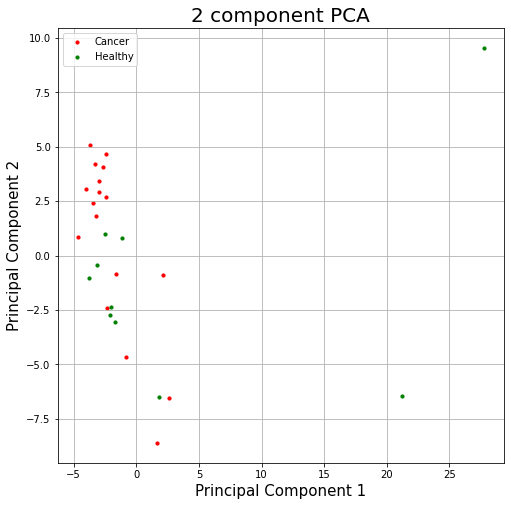

In [48]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [49]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [50]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


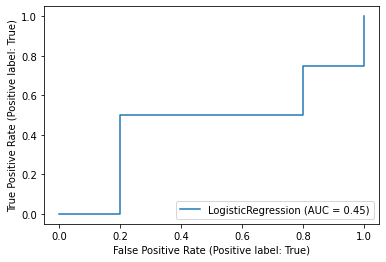

In [51]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [52]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [53]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[20:59:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


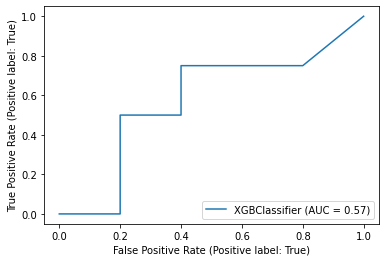

In [54]:
plot_roc_curve(model, X_test, y_test)

### Exported data

In [55]:
mirnas[:10]

Index(['hsa-let-7a-5p', 'hsa-let-7b-3p', 'hsa-let-7b-5p', 'hsa-let-7c',
       'hsa-let-7d-3p', 'hsa-let-7d-5p', 'hsa-let-7e-5p', 'hsa-let-7f-5p',
       'hsa-let-7g-5p', 'hsa-let-7i-3p'],
      dtype='object')

In [56]:
from Scripts import converters

In [57]:
sequences = converters.canonical_to_seq(mirnas, True)

In [58]:
sequences.count(None)

2

In [59]:
sequences = np.array(sequences)
mask = sequences != None
sequences = sequences[mask]
adj_norm_log_table = adj_norm_log_table.loc[:, mask]
#adj_norm_log_table *= -1
adj_norm_log_table.head()

,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-5p,hsa-let-7f-5p,hsa-let-7g-5p,hsa-let-7i-3p,...,hsa-miR-652-3p,hsa-miR-660-5p,hsa-miR-766-3p,hsa-miR-885-5p,hsa-miR-92a-3p,hsa-miR-93-3p,hsa-miR-93-5p,hsa-miR-95,hsa-miR-99a-5p,hsa-miR-99b-5p
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
H01,5.639559,7.450720,5.837853,7.028476,7.767380,6.845148,7.335819,6.906337,5.858259,3.370452,...,7.871408,6.158268,2.336633,3.846127,5.278696,8.335886,5.810623,4.164659,7.631395,7.365496
S03,5.826507,7.781354,6.208752,7.085708,7.717015,6.931276,7.435393,7.121464,5.983808,6.833975,...,7.529330,5.967331,2.336633,3.846127,5.254302,3.941590,5.795044,8.527561,7.482051,7.198359
S12,5.881301,7.022161,6.428841,7.125478,7.318343,6.995904,7.675206,7.022923,5.622263,6.675805,...,7.330264,5.651642,2.336633,7.497499,4.902266,7.555258,5.191153,8.116929,7.292686,7.116662
A05,5.682728,7.730395,6.110157,6.980124,7.601208,6.989763,7.260271,6.760162,5.735584,3.370452,...,7.725504,6.111550,2.336633,7.861994,5.177114,7.972648,5.511429,8.263318,7.513229,7.192996
S11,5.536672,6.981062,5.750086,6.821242,7.114250,6.715270,7.095189,6.903307,5.518069,6.929963,...,7.117851,5.538906,2.336633,7.857613,4.923223,7.515923,4.952352,8.437531,7.268577,6.992180


In [60]:
adj_norm_log_table.columns = sequences
adj_norm_log_table["cancer"] = 1 - controls
adj_norm_log_table.head()

C:\Users\olefr\AppData\Local\Temp/ipykernel_17848/2605232209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_norm_log_table["cancer"] = 1 - controls


,UGAGGUAGUAGGUUGUAUAGUU,CUAUACAACCUACUGCCUUCCC,UGAGGUAGUAGGUUGUGUGGUU,GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCUGGGAGUUAACUGUACAACCUUCUAGCUUUCCUUGGAGC,CUAUACGACCUGCUGCCUUUCU,AGAGGUAGUAGGUUGCAUAGUU,UGAGGUAGGAGGUUGUAUAGUU,UGAGGUAGUAGAUUGUAUAGUU,UGAGGUAGUAGUUUGUACAGUU,CUGCGCAAGCUACUGCCUUGCU,...,UACCCAUUGCAUAUCGGAGUUG,ACUCCAGCCCCACAGCCUCAGC,UCCAUUACACUACCCUGCCUCU,UAUUGCACUUGUCCCGGCCUGU,ACUGCUGAGCUAGCACUUCCCG,CAAAGUGCUGUUCGUGCAGGUAG,UUCAACGGGUAUUUAUUGAGCA,AACCCGUAGAUCCGAUCUUGUG,CACCCGUAGAACCGACCUUGCG,cancer
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
H01,5.639559,7.450720,5.837853,7.028476,7.767380,6.845148,7.335819,6.906337,5.858259,3.370452,...,6.158268,2.336633,3.846127,5.278696,8.335886,5.810623,4.164659,7.631395,7.365496,0
S03,5.826507,7.781354,6.208752,7.085708,7.717015,6.931276,7.435393,7.121464,5.983808,6.833975,...,5.967331,2.336633,3.846127,5.254302,3.941590,5.795044,8.527561,7.482051,7.198359,1
S12,5.881301,7.022161,6.428841,7.125478,7.318343,6.995904,7.675206,7.022923,5.622263,6.675805,...,5.651642,2.336633,7.497499,4.902266,7.555258,5.191153,8.116929,7.292686,7.116662,1
A05,5.682728,7.730395,6.110157,6.980124,7.601208,6.989763,7.260271,6.760162,5.735584,3.370452,...,6.111550,2.336633,7.861994,5.177114,7.972648,5.511429,8.263318,7.513229,7.192996,1
S11,5.536672,6.981062,5.750086,6.821242,7.114250,6.715270,7.095189,6.903307,5.518069,6.929963,...,5.538906,2.336633,7.857613,4.923223,7.515923,4.952352,8.437531,7.268577,6.992180,1


In [61]:
adj_norm_log_table.to_csv("../TransformedData/Zaporozhchenko2018_raw.csv", index=False)